In [1]:
# Filter tensorflow version warnings
import os
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import gym
from stable_baselines.common.policies import CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2

In [3]:
## DEFAULT 'CarRacing-v3' environment values

# continuous action = (steering, throttle, brake)
ACT = [[0, 0, 0], [-0.4, 0, 0], [0.4, 0, 0], [0, 1, 0], [0, 0, 0.8]]
# discrete actions: center_steering and no gas/brake, left, right, accel, brake  
#     --> actually a good choice, because car_dynamics softens the action's diff for gas and steering

##REWARDS 
# reward given each step: step, distance to centerline, speed, steer angle
# reward given on new tile: % of advance
# reward given at episode end: finished, patience exceeded, out of bounds, steps exceeded
# reward for Obstacles:  obstacle hit (each step), obstacle collided (episode end)
GYM_REWARD = [-0.1, 0.0, 0.0, 0.0,   10.0,     0,  -0, -100, -0,     -0, -0 ]
STD_REWARD = [-0.1, 0.0, 0.0, 0.0,    1.0,   100, -20, -100, -50,    -0, -0 ]
CONT_REWARD =[-0.1, 0.0, 0.0, 0.0,    1.0,   100, -20, -100, -50,    -5, -100 ]
# see docu for RETURN computation details

In [4]:
## My environment proposal
ACT = [[0, 0, 0], [-0.4, 0, 0], [0.4, 0, 0], [0, 0.6, 0], [0, 0, 0.8]]
CONT_REWARD = [-0.05, 0.1, 0.0, 0.0,    2.0,   100, -20, -100, -50,   -10, -100 ]
obst_loc = [5, -12, 25, 50, -75, -37, 62, 87, 95]

env1 = gym.make('CarRacing-v3',
       use_track = 5,             # number of times to use the same Track, [1-100]. More than 20 high risk of overfitting!!
       episodes_per_track = 10,    # number of evenly distributed Starting Points on each track [1-20]
       discre = ACT,              # Action discretization function, format [[steer0, throtle0, brake0], [steer1, ...], ...]. 
                                  # None for continous
       tr_complexity = 10,        # generated Track geometric Complexity, [6-20]
       tr_width = 45,             # relative Track Width, [30-50]
       patience = 2,              # max time in secs without Progress, [0.5-20]
       off_track = 2,             # max time in secs Driving on Grass, [0-5]
       indicators = True,         # show or not bottom info Panel
       game_color = 2,            # State color option: 0 = RGB, 1 = Grayscale, 2 = Green only
       frames_per_state = 4,      # stacked (rolling history) Frames on each state [1-inf], latest observation always on first Frame
       skip_frames = 3,           # number of consecutive Frames to skip on history [0-4]
       f_reward = CONT_REWARD,    # Reward Funtion coeficients, refer to Docu for details
       num_obstacles = 5,         # Obstacle objects placed on track [0-10]
       end_on_contact = False,    # stop episode on contact with obstacle, not recommended for starting-phase of training
       obst_location = obst_loc,  # array pre-setting obstacle Location, in %track. Negative value means tracks's left-hand side.
                       #0         # 0 for random location
       oily_patch = False,        # use all obstacles as Low-friction road (oily patch)
       verbose = 3      )


In [5]:
print(env1.action_space)
print(env1.observation_space)
env1.reset()
env1.render()
env1.metadata

Discrete(5)
Box(0, 255, (96, 96, 4), uint8)
Track generation: 1025..1289 -> 264-tiles track, complex 10
5  obstacles on tiles:  [  13  -32   66  132 -197]


{'render.modes': ['human', 'rgb_array', 'state_pixels'],
 'FPS, 1/timebase': 33.333333333333336,
 'Zoom_level': 1.5,
 'Flight start': False,
 'show_track_1st': True,
 'state_pixels frame size': [96, 96]}

In [6]:
batch_size = 256
epochs = 4
updates = 100  #not nearly enough to get it working!!!

model = PPO2(CnnPolicy, env1, verbose=1, n_steps=batch_size, # seed=314, n_cpu_tf_sess=1,
             gamma=0.99, learning_rate=0.00025, nminibatches=epochs, ent_coef=0.01, vf_coef=0.5) 

Wrapping the env in a DummyVecEnv.


In [7]:
model.learn(total_timesteps = updates*batch_size)

1  cut by time without progress. Steps 148  %advance 1.5  played reward 6.84  last penalty -20
-------------------------------------
| approxkl           | 0.0074811634 |
| clipfrac           | 0.07421875   |
| explained_variance | -0.0214      |
| fps                | 41           |
| n_updates          | 1            |
| policy_entropy     | 1.6007288    |
| policy_loss        | -0.017682012 |
| serial_timesteps   | 256          |
| time_elapsed       | 0            |
| total_timesteps    | 256          |
| value_loss         | 7.2031884    |
-------------------------------------
2  cut by time without progress. Steps 197  %advance 1.9  played reward 5.74  last penalty -20
--------------------------------------
| approxkl           | 0.005465879   |
| clipfrac           | 0.05078125    |
| explained_variance | 0.117         |
| fps                | 45            |
| n_updates          | 2             |
| policy_entropy     | 1.5686367     |
| policy_loss        | -0.0023071254 |
| se

-------------------------------------
| approxkl           | 0.0017408752 |
| clipfrac           | 0.005859375  |
| explained_variance | 0.347        |
| fps                | 57           |
| n_updates          | 15           |
| policy_entropy     | 1.5297288    |
| policy_loss        | -0.010225714 |
| serial_timesteps   | 3840         |
| time_elapsed       | 69.1         |
| total_timesteps    | 3840         |
| value_loss         | 5.504041     |
-------------------------------------
13  cut by time without progress. Steps 471  %advance 6.8  played reward 16.49  last penalty -20
-------------------------------------
| approxkl           | 0.007263623  |
| clipfrac           | 0.115234375  |
| explained_variance | 0.457        |
| fps                | 55           |
| n_updates          | 16           |
| policy_entropy     | 1.523886     |
| policy_loss        | 0.0022451722 |
| serial_timesteps   | 4096         |
| time_elapsed       | 73.6         |
| total_timesteps    | 4096  

28  cut by time without progress. Steps 160  %advance 2.2  played reward -1.15  last penalty -20
29  cut by time without progress. Steps 155  %advance 4.1  played reward 3.83  last penalty -20
--------------------------------------
| approxkl           | 0.007951649   |
| clipfrac           | 0.08691406    |
| explained_variance | 0.881         |
| fps                | 55            |
| n_updates          | 29            |
| policy_entropy     | 1.3895911     |
| policy_loss        | -0.0066913604 |
| serial_timesteps   | 7424          |
| time_elapsed       | 134           |
| total_timesteps    | 7424          |
| value_loss         | 2.4854913     |
--------------------------------------
30  cut by time without progress. Steps 144  %advance 4.1  played reward 0.44  last penalty -20
--------------------------------------
| approxkl           | 0.008721048   |
| clipfrac           | 0.15429688    |
| explained_variance | 0.888         |
| fps                | 52            |
| n_updat

-------------------------------------
| approxkl           | 0.010256896  |
| clipfrac           | 0.20996094   |
| explained_variance | 0.958        |
| fps                | 54           |
| n_updates          | 42           |
| policy_entropy     | 1.4796056    |
| policy_loss        | -0.011275554 |
| serial_timesteps   | 10752        |
| time_elapsed       | 195          |
| total_timesteps    | 10752        |
| value_loss         | 0.6940202    |
-------------------------------------
45  cut by time without progress. Steps 129  %advance 1.5  played reward 4.81  last penalty -20
obstacle hit
obstacle hit
------------------------------------
| approxkl           | 0.003986756 |
| clipfrac           | 0.036132812 |
| explained_variance | -0.0665     |
| fps                | 54          |
| n_updates          | 43          |
| policy_entropy     | 1.5322446   |
| policy_loss        | -0.00358087 |
| serial_timesteps   | 11008       |
| time_elapsed       | 200         |
| total_timest

5  cut by time without progress. Steps 226  %advance 4.4  played reward 8.21  last penalty -20
obstacle hit
obstacle hit
6  cut by time without progress. Steps 181  %advance 9.3  played reward -117.57  last penalty -20
--------------------------------------
| approxkl           | 0.002192925   |
| clipfrac           | 0.015625      |
| explained_variance | -0.00314      |
| fps                | 57            |
| n_updates          | 57            |
| policy_entropy     | 1.3323977     |
| policy_loss        | -0.0049893535 |
| serial_timesteps   | 14592         |
| time_elapsed       | 263           |
| total_timesteps    | 14592         |
| value_loss         | 192.70055     |
--------------------------------------
obstacle hit
obstacle hit
--------------------------------------
| approxkl           | 0.003054144   |
| clipfrac           | 0.013671875   |
| explained_variance | 0.0817        |
| fps                | 59            |
| n_updates          | 58            |
| policy_entro

15  cut by time without progress. Steps 210  %advance 4.4  played reward 13.84  last penalty -20
obstacle hit
obstacle hit
-------------------------------------
| approxkl           | 0.0068251155 |
| clipfrac           | 0.07519531   |
| explained_variance | -0.196       |
| fps                | 59           |
| n_updates          | 72           |
| policy_entropy     | 1.4659346    |
| policy_loss        | -0.011496143 |
| serial_timesteps   | 18432        |
| time_elapsed       | 329          |
| total_timesteps    | 18432        |
| value_loss         | 162.12943    |
-------------------------------------
16  cut by time without progress. Steps 442  %advance 12.2  played reward -85.52  last penalty -20
-------------------------------------
| approxkl           | 0.002540518  |
| clipfrac           | 0.01953125   |
| explained_variance | 0.821        |
| fps                | 58           |
| n_updates          | 73           |
| policy_entropy     | 1.4448733    |
| policy_loss     

23  cut by time without progress. Steps 839  %advance 24.8  played reward -130.55  last penalty -20
-------------------------------------
| approxkl           | 0.014397408  |
| clipfrac           | 0.27246094   |
| explained_variance | 0.349        |
| fps                | 58           |
| n_updates          | 87           |
| policy_entropy     | 1.2820979    |
| policy_loss        | -0.006179719 |
| serial_timesteps   | 22272        |
| time_elapsed       | 395          |
| total_timesteps    | 22272        |
| value_loss         | 1.1878237    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0043234164  |
| clipfrac           | 0.044921875   |
| explained_variance | 0.954         |
| fps                | 60            |
| n_updates          | 88            |
| policy_entropy     | 1.3792924     |
| policy_loss        | -0.0061180256 |
| serial_timesteps   | 22528         |
| time_elapsed       | 399           |
| total_timestep

In [8]:
import pickle

model.save("contact_ppo_4f3s_green_bs256_indic", cloudpickle=True)
#param_list=model.get_parameter_list()
param = model.get_parameters()

f = open("contact_ppo_cnn_agentI_param.pkl","wb")
#pickle.dump(param_list,f)
pickle.dump(param,f)
f.close()

In [12]:
# Enjoy trained agent

#obs=env1.reset()  # uses the last trainig track!
obs = env1.reset_track()  # creates new random track for testing

done=False
pasos=0
_states=None

while not done and pasos<1002:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env1.step(action)
    env1.render()
    pasos+=1


Track generation: 930..1172 -> 242-tiles track, complex 10
5  obstacles on tiles:  [  12  -29   60  120 -181]
1  cut by time without progress. Steps 67  %advance 0.8  played reward 3.29  last penalty -20


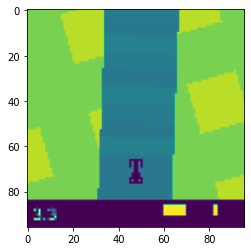

In [10]:
import matplotlib.pyplot as plt
plt.imshow(obs[:,:,0])


In [11]:
env1.close()